# Spam classifier using classic MLP + LTSM

## We will use the popular SMS Spam Collection dataset. It contains around 5,500 text messages labeled as either "spam" or "not spam."

In [9]:
import pandas as pd

url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=["label", "message"])

In [10]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Let's perform text preprocessing. We will remove extra spaces, convert words to lowercase, clean messages from punctuation marks, and remove stop words.

In [12]:
import unicodedata
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Creating set of stop-words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Creating dictionary for clean data from puctuation
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))

# Creating capitalizer func to preprocess text data
def preprocess_text(text):
    if isinstance(text, str): 
        text = text.strip() # deleting spaces
        text = text.lower() # lowercase
        text = text.translate(punctuation) # clear punctuation
        words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words] # delete stop words
        return ' '.join(words)  
    return ''  

data['cleaned_message'] = data['message'].apply(preprocess_text) #creatint new column with cleaned messages



data.head()

,label,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


## Let's look at the data description

In [14]:
data.describe()

,label,message,cleaned_message
count,5572,5572,5572
unique,2,5169,5117
top,ham,"Sorry, I'll call later",sorry ill call later
freq,4825,30,30


## We can see that the dataset contains duplicates. Let's remove them.

In [16]:
data_cleaned = data.drop_duplicates(subset=['cleaned_message']) #deleting duplicates
data_cleaned.head()

,label,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


## Let's create a new DataFrame without the column containing the raw (uncleaned) messages.

In [18]:
data_dcleanned = data_cleaned.drop('message', axis=1) # deleting 'message'
data_dcleanned.head()


,label,cleaned_message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


## Let's take a look at the description of our data.

In [20]:
data_dcleanned.describe()


,label,cleaned_message
count,5117,5117
unique,2,5117
top,ham,go jurong point crazy available bugis n great ...
freq,4485,1


## Let's analyze the distribution of our labels by count.

In [22]:
data['label'].value_counts()


label
ham     4825
spam     747
Name: count, dtype: int64

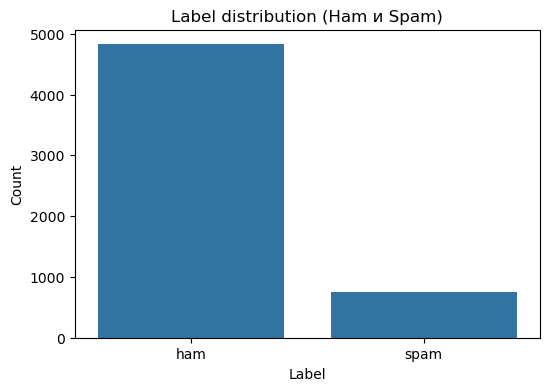

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 4)) #creating histogramm
sns.countplot(x='label', data=data) 
plt.title('Label distribution (Ham и Spam)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


## This code preprocesses text data using a Bag of Words (BoW) representation and builds a binary text classification model. It uses CountVectorizer for feature extraction and LabelEncoder for label encoding. A simple feedforward neural network with two hidden layers is trained using Keras, and performance is evaluated on a test set.

In [53]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, Input

# Set a seed for the pseudo-random number generator to ensure reproducibility
np.random.seed(0)

# Create a Bag of Words (BoW) using CountVectorizer
# Using the top 400 most frequent words, with a binary presence indicator
vectorizer = CountVectorizer(max_features=400)
features = vectorizer.fit_transform(data['cleaned_message'])

# Check the size of the feature matrix
print("Feature matrix size:", features.shape)  # Expected: (number of messages, 400)

# Encode the labels to (0, 1)
encoder = LabelEncoder()
targets = encoder.fit_transform(data['label'])

# Split the data into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)

# Convert sparse matrices to dense numpy arrays
features_train = features_train.toarray()
features_test = features_test.toarray()

# Set the number of features (expected to be 400)
number_of_features = features_train.shape[1]

# Initialize the neural network model
network = models.Sequential()

# Add input layer
network.add(Input(shape=(number_of_features,)))

# Add fully connected (Dense) layers with ReLU activation
network.add(layers.Dense(units=16, activation="relu"))
network.add(layers.Dense(units=16, activation="relu"))

# Add a fully connected output layer with sigmoid activation
network.add(layers.Dense(units=1, activation="sigmoid"))

# Compile the model with binary crossentropy loss and RMSProp optimizer
network.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

# Train the neural network
history = network.fit(
    features_train,
    targets_train,
    epochs=23,
    verbose=1,
    batch_size=100,
    validation_data=(features_test, targets_test))


Feature matrix size: (5572, 400)
Epoch 1/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7302 - loss: 0.6560 - val_accuracy: 0.9309 - val_loss: 0.5235
Epoch 2/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9320 - loss: 0.4770 - val_accuracy: 0.9570 - val_loss: 0.3320
Epoch 3/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.2885 - val_accuracy: 0.9677 - val_loss: 0.1982
Epoch 4/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9682 - loss: 0.1731 - val_accuracy: 0.9713 - val_loss: 0.1309
Epoch 5/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9748 - loss: 0.1131 - val_accuracy: 0.9731 - val_loss: 0.1013
Epoch 6/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0873 - val_accuracy: 0.9767 - val_loss: 0.0866
Epoch 7/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9771 - loss: 0.0718 - val_accuracy: 0.9803 - val_loss: 0.0805
Epoch 8/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9814 - loss: 0.0628 -

## This code plots training and validation loss over epochs to evaluate the model's performance. The loss values are retrieved from the training history, and matplotlib is used to visualize trends, helping identify overfitting or underfitting.

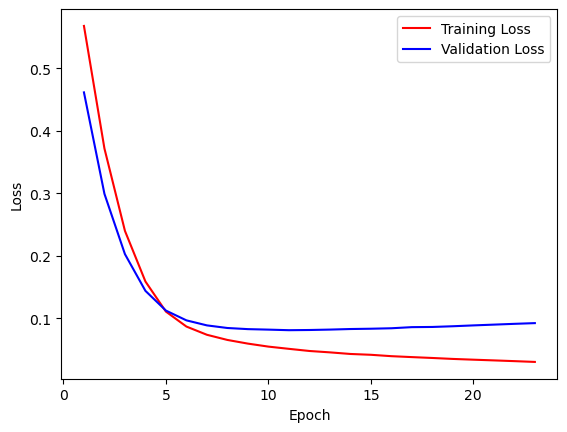

In [27]:
# Retrieve training and testing loss history
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create a counter for the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize the loss history
plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## This code plots training and validation accuracy over epochs to assess model performance. Accuracy values are retrieved from the training history and visualized using matplotlib.

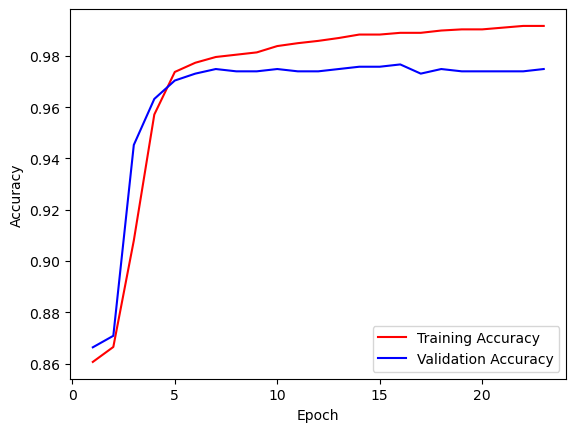

In [29]:
# Retrieve training and testing accuracy history
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.plot(epoch_count, training_accuracy, "r-")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize the accuracy history
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show();



## This code preprocesses text data by tokenizing and padding sequences, then builds an LSTM-based neural network for binary text classification. It includes an embedding layer, an LSTM layer, and a sigmoid-activated output layer, trained with the Adam optimizer and binary cross-entropy loss.

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=400)  # Limit to the 400 most common words
tokenizer.fit_on_texts(data['cleaned_message'])

# Convert the texts to sequences of integers
sequences = tokenizer.texts_to_sequences(data['cleaned_message'])

# Pad the sequences to ensure they are all the same length
max_sequence_length = 800  # You can set this to the maximum length of your sequences
features = pad_sequences(sequences, maxlen=max_sequence_length)

encoder = LabelEncoder()
targets = encoder.fit_transform(data['label'])

# Split the data into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)

network = models.Sequential()

# Add an embedding layer
network.add(layers.Embedding(input_dim=number_of_features, output_dim=32))

# Add an LSTM layer with 128 units (Long Short-Term Memory)
network.add(layers.LSTM(units=32))

# Add a fully connected layer with a sigmoid activation function
network.add(layers.Dense(units=1, activation="sigmoid"))

# Compile the neural network
network.compile(
    loss="binary_crossentropy",  # Cross-entropy loss
    optimizer="Adam",  # Adam optimizer
    metrics=["accuracy"]  # Accuracy metric
)

# Train the neural network
history = network.fit(
    features_train,  # Features
    targets_train,  # Targets
    epochs=10,  # Number of epochs
    verbose=1,  # Do not print the description after each epoch
    batch_size=100,  # Number of samples per batch
    validation_data=(features_test, targets_test)  # Test data
)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8617 - loss: 0.4898 - val_accuracy: 0.8789 - val_loss: 0.2846
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9058 - loss: 0.2504 - val_accuracy: 0.9543 - val_loss: 0.1758
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9573 - loss: 0.1512 - val_accuracy: 0.9713 - val_loss: 0.1069
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.9765 - loss: 0.0953 - val_accuracy: 0.9785 - val_loss: 0.0828
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9777 - loss: 0.0766 - val_accuracy: 0.9794 - val_loss: 0.0743
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9840 - loss: 0.0608 - val_accuracy: 0.9794 - val_loss: 0.0721
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.9787 - loss: 0.0683 - val_accuracy: 0.9785 - val_loss: 0.0748
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9883 - loss: 0.0465 - val_accuracy: 0.

## This code plots training and validation loss over epochs to evaluate the model's performance. The loss values are retrieved from the training history, and matplotlib is used to visualize trends, helping identify overfitting or underfitting.

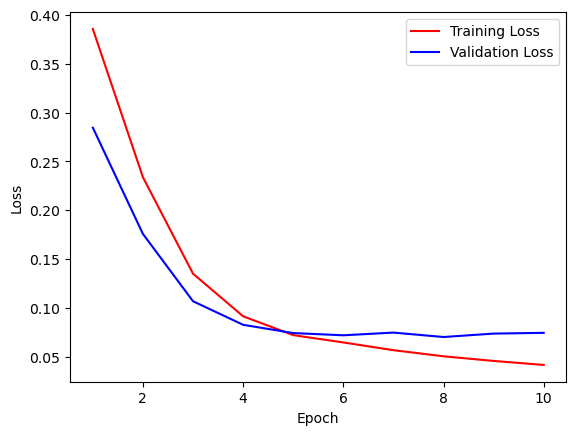

In [33]:
# Retrieve training and testing loss history
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create a counter for the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize the loss history
plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## This code plots training and validation accuracy over epochs to assess model performance. Accuracy values are retrieved from the training history and visualized using matplotlib.

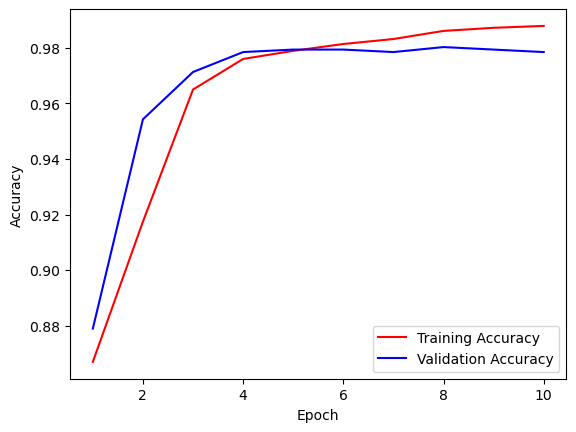

In [35]:
# Retrieve training and testing accuracy history
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.plot(epoch_count, training_accuracy, "r-")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize the accuracy history
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show();